In [19]:
import pandas as pd

# Đường dẫn đến tệp dữ liệu CSV
file_path = 'NDVI_Pixels_Time_Series_All_Years_quehuong.csv'

# Đọc tệp CSV vào DataFrame
data = pd.read_csv(file_path)
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  1200 non-null   object 
 1   NDVI          1200 non-null   float64
 2   year          1200 non-null   float64
 3   .geo          1200 non-null   object 
dtypes: float64(2), object(2)
memory usage: 37.6+ KB


In [20]:
data[['year_number', 'pixel_id']] = data['system:index'].str.split('_', expand=True)
data['year_number'] = data['year'].astype(int)
data['pixel_id'] = data['pixel_id'].astype(int)

# Chuyển đổi DataFrame để mỗi dòng là một pixel và mỗi cột là NBR của từng năm
pivot_df = data.pivot(index='pixel_id', columns='year_number', values='NDVI')

# Đổi tên các cột để phản ánh năm theo thứ tự (Year_1, Year_2, ..., Year_38)
pivot_df.columns = [f'Year_{col}' for col in pivot_df.columns]

# Hiển thị kết quả
pivot_df.reset_index(inplace=True)
pivot_df.head()
pivot_df.to_csv('pivot_data.csv', index=False)

In [21]:
import xarray as xr
data = pivot_df.dropna()
years = [int(col.split('_')[1]) for col in data.columns if col.startswith("Year_")]
pixel_ids = data['pixel_id']

# Chuyển đổi DataFrame sang xarray.Dataset
ds = xr.Dataset(
    {
        "NDVI": (["pixel_id", "year"], data.drop(columns="pixel_id").values)
    },
    coords={
        "pixel_id": pixel_ids,
        "time": years
    }
)

# Hiển thị Dataset
print(ds)

<xarray.Dataset>
Dimensions:   (pixel_id: 48, year: 25, time: 25)
Coordinates:
  * pixel_id  (pixel_id) int32 0 1 2 3 4 5 6 7 8 ... 39 40 41 42 43 44 45 46 47
  * time      (time) int32 1986 1987 1988 1989 1990 ... 2006 2007 2008 2009 2010
Dimensions without coordinates: year
Data variables:
    NDVI      (pixel_id, year) float64 0.2686 0.1902 0.123 ... 0.1047 0.2587


In [22]:
# Đọc tệp CSV vào DataFrame
data = pd.read_csv("pivot_data.csv")  
years = [int(col.split('_')[1]) for col in data.columns if col.startswith("Year_")]
pixel_ids = data['pixel_id']

ds = xr.Dataset(
    {
        "NDVI": (["pixel_id", "year"], data.drop(columns="pixel_id").values)
    },
    coords={
        "pixel_id": pixel_ids,
        "time": years
    }
)

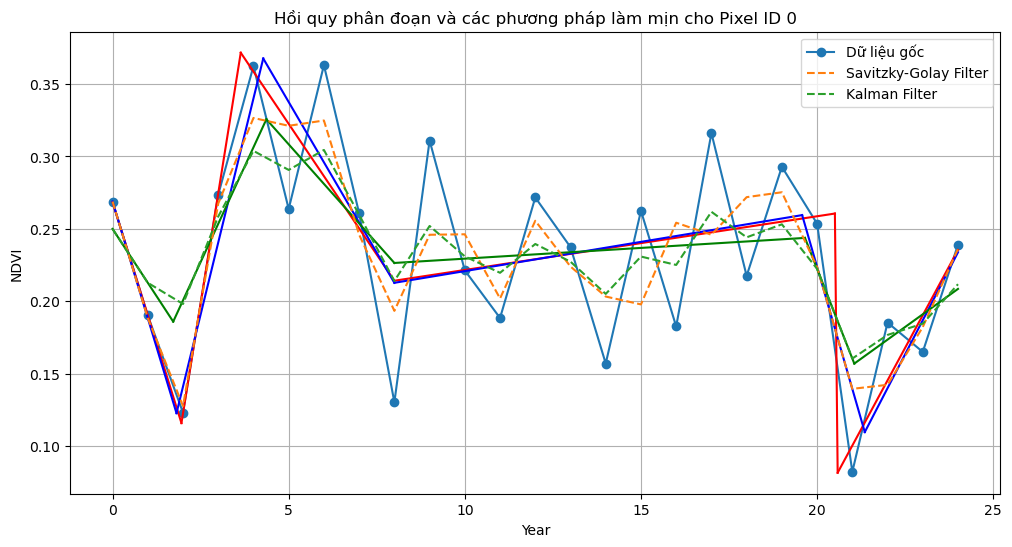

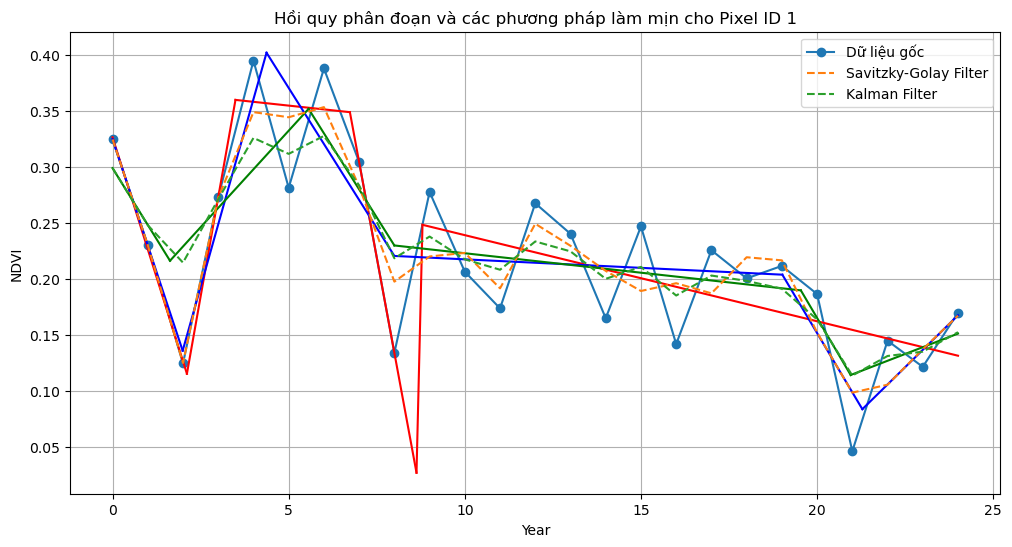

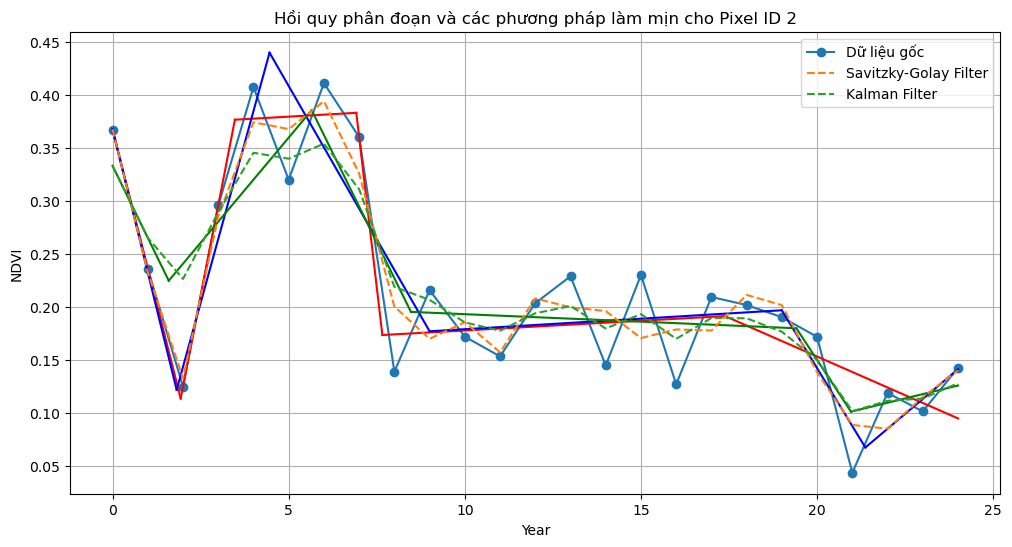

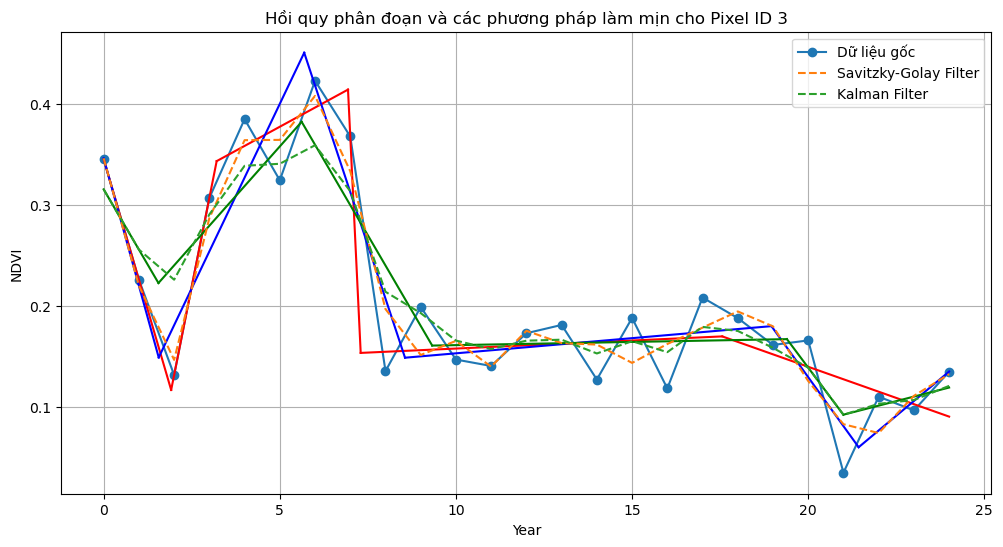

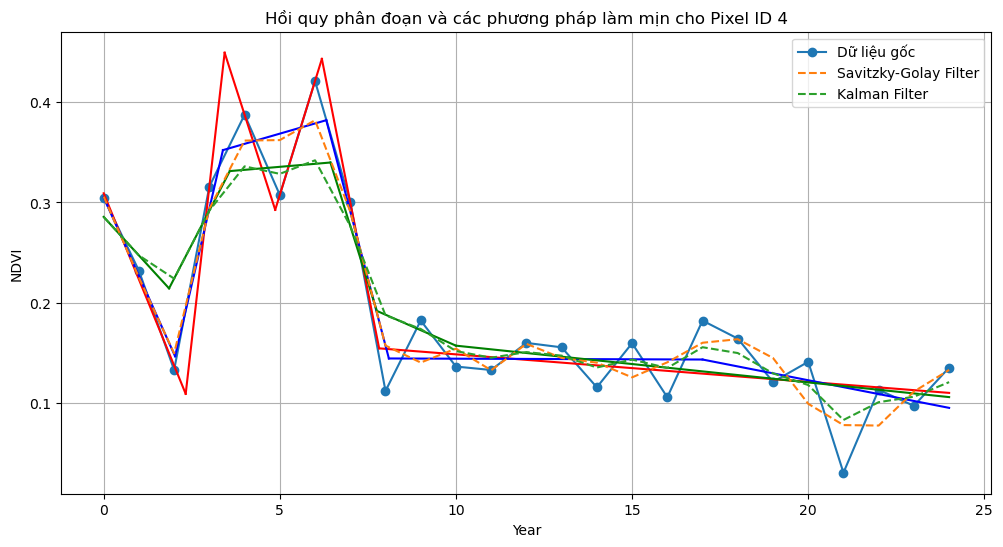

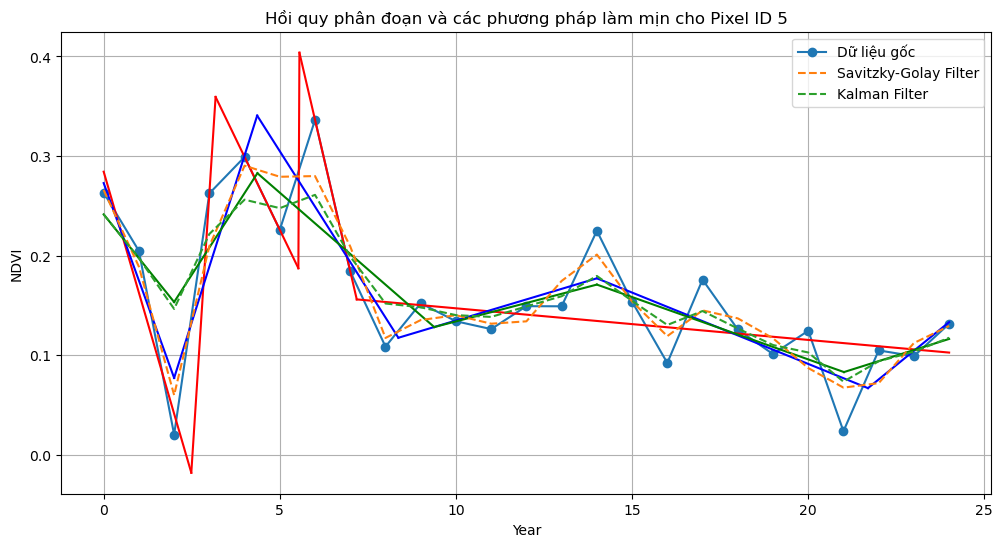

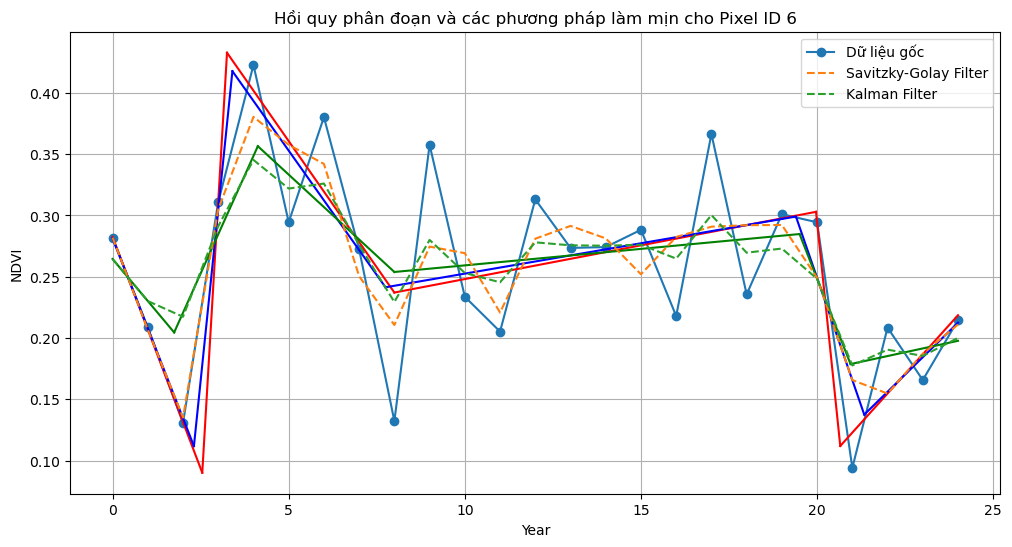

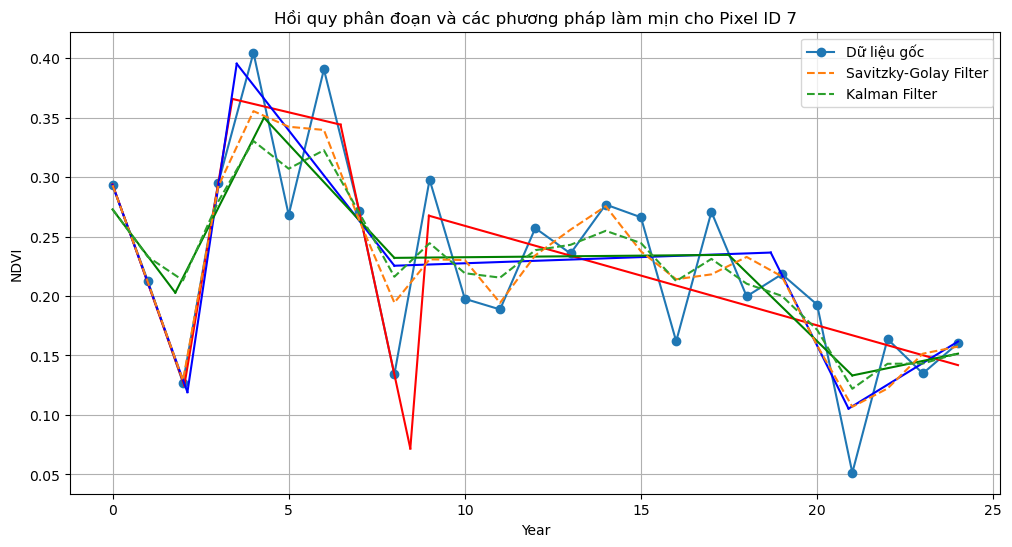

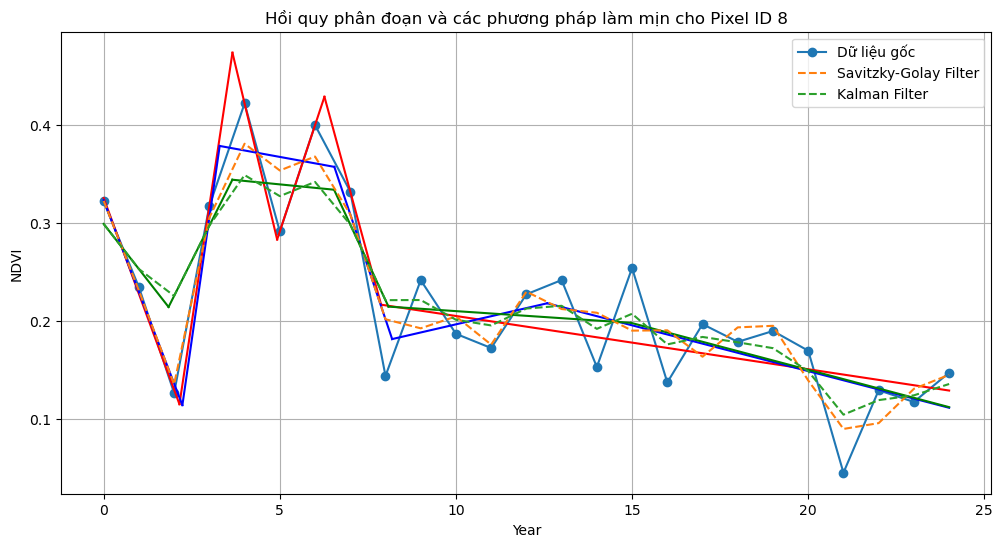

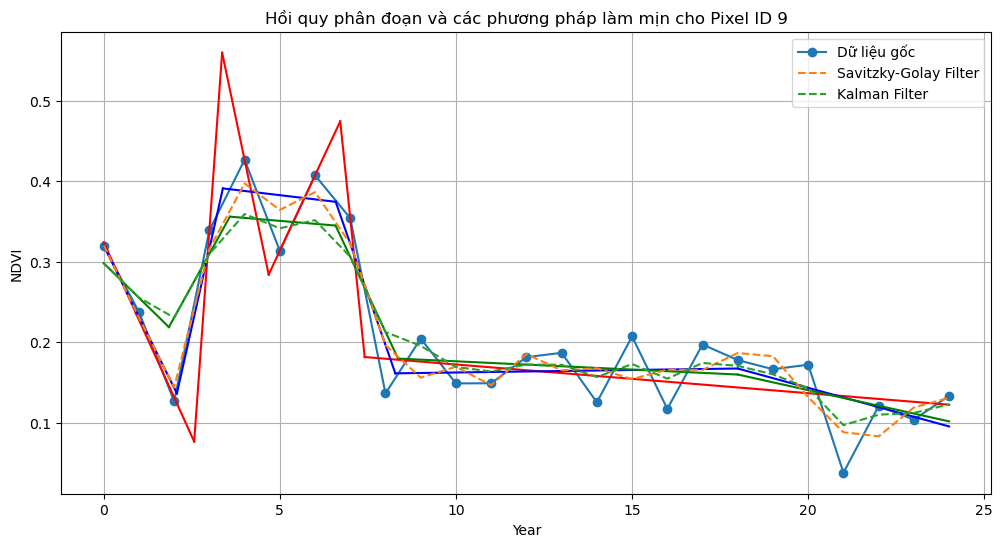

KeyboardInterrupt: 

In [28]:
import matplotlib.pyplot as plt
import pwlf
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d, median_filter
from pykalman import KalmanFilter
import numpy as np


# Thiết lập tham số hồi quy và làm mịn
n_segments = 6  # Số đoạn phân đoạn cho pwlf
sigma = 2  # Tham số sigma cho Gaussian filter
window_length = 7  # Chiều dài cửa sổ cho Savitzky-Golay filter
polyorder = 5  # Bậc đa thức cho Savitzky-Golay filter

# Lặp qua từng pixel
for pixel_id in ds.pixel_id.values:
    ndvi_values = ds.NDVI.sel(pixel_id=pixel_id).values

    # Hồi quy phân đoạn bằng pwlf
    time_numeric = np.arange(len(ndvi_values))
    my_pwlf = pwlf.PiecewiseLinFit(time_numeric, ndvi_values)
    breakpoints = my_pwlf.fit(n_segments)

    # Áp dụng các phương pháp làm mịn
    # 1. Savitzky-Golay
    smoothed_savgol = savgol_filter(ndvi_values, window_length=window_length, polyorder=polyorder)
    my_pwlf_savgol = pwlf.PiecewiseLinFit(time_numeric, smoothed_savgol)
    breakpoints_savgol = my_pwlf_savgol.fit(n_segments)

    # 4. Kalman Filter
    kf = KalmanFilter(initial_state_mean=ndvi_values[0], n_dim_obs=1)
    state_means, _ = kf.smooth(ndvi_values)
    smoothed_kalman = state_means.flatten()
    my_pwlf_kalman = pwlf.PiecewiseLinFit(time_numeric, smoothed_kalman)
    breakpoints_kalman = my_pwlf_kalman.fit(n_segments)

    # Vẽ biểu đồ cho từng pixel
    plt.figure(figsize=(12, 6))
    plt.plot(time_numeric, ndvi_values, 'o-', label='Dữ liệu gốc')
    for i in range(1, len(breakpoints)):
        x_segment = np.linspace(breakpoints[i-1], breakpoints[i], num=100)
        y_segment = my_pwlf.predict(x_segment)
        plt.plot(x_segment, y_segment, '-', color='red')
    
    for i in range(1, len(breakpoints_savgol)):
        x_segment = np.linspace(breakpoints_savgol[i-1], breakpoints_savgol[i], num=100)
        y_segment = my_pwlf_savgol.predict(x_segment)
        plt.plot(x_segment, y_segment, '-', color='blue')

    for i in range(1, len(breakpoints_kalman)):
        x_segment = np.linspace(breakpoints_kalman[i-1], breakpoints_kalman[i], num=100)
        y_segment = my_pwlf_kalman.predict(x_segment)
        plt.plot(x_segment, y_segment, '-', color='green')

    # Vẽ các đường làm mịn khác nhau
    plt.plot(time_numeric, smoothed_savgol, '--', label='Savitzky-Golay Filter')
    plt.plot(time_numeric, smoothed_kalman, '--', label='Kalman Filter')

    # Định dạng biểu đồ
    plt.xlabel('Year')
    plt.ylabel('NDVI')
    plt.title(f'Hồi quy phân đoạn và các phương pháp làm mịn cho Pixel ID {pixel_id}')
    plt.legend()
    plt.grid(True)
    plt.show()